In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [46]:
print(type([1,2,3])is list)

True


In [47]:
torch.manual_seed(42)

In [48]:
device= torch.device('cuda'if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda


In [49]:
df= pd.read_csv('/content/fmnist_small.csv')

In [50]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [51]:
df.shape

(6000, 785)

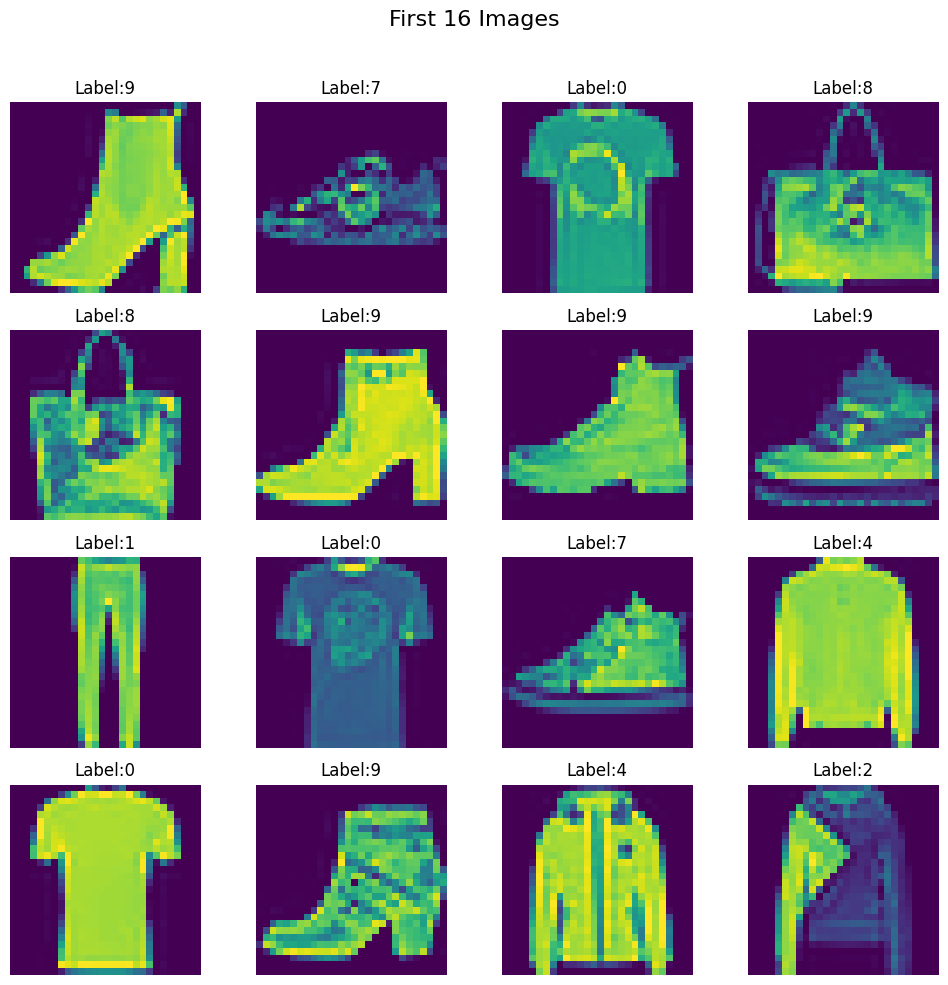

In [52]:
fig,axes= plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 Images",fontsize=16)

for i, ax in enumerate(axes.flat):
    img= df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label:{df.iloc[i,0]}")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [53]:
x= df.iloc[:,1:].values
y= df.iloc[:,0].values

In [54]:
x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.2, random_state=42)

In [55]:
x_train=x_train/255.0
x_test= x_test/255.0

In [56]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features= torch.tensor(features, dtype= torch.float32)
        self.labels=torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)
    def __getitem__(self, index):
        return self.features[index],self.labels[index]

In [57]:
train_dataset= CustomDataset(x_train, y_train)

In [58]:
test_dataset= CustomDataset(x_test, y_test)

In [59]:
class MyNN(nn.Module):
  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
      super().__init__()
      layers=[]
      for i in range(num_hidden_layers):
        layers.append(nn.Linear(input_dim, neurons_per_layer))
        layers.append(nn.BatchNorm1d(neurons_per_layer))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        input_dim= neurons_per_layer

      layers.append(nn.Linear(neurons_per_layer,output_dim))

      self.model= nn.Sequential(*layers)
  def forward(self,x):
      return self.model(x)


In [60]:
def objective(trial):
  num_hidden_layers= trial.suggest_int("num_hidden_layer",1,5)
  neurons_per_layer= trial.suggest_int("neurons_per_layer",8,128,step=8)

  epochs= trial.suggest_int("epochs",10,50,step=10)
  learning_rate=trial.suggest_float("learning_rate",1e-5,1e-1, log=True)
  dropout_rate= trial.suggest_float("dropout_rate", 0.1,0.5, step=0.1)
  batch_size= trial.suggest_categorical("batch_size",[16,32,64,128])
  optimizer_name= trial.suggest_categorical("optimizer",['Adam','SGD','RMSprop'])
  weight_decay= trial.suggest_float("weight_decay",1e-5,1e-3, log=True)

  train_loader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader= DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  input_dim=784
  output_dim=10

  model= MyNN(input_dim,output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)


  criterion= nn.CrossEntropyLoss()
  optimizer= optim.SGD(model.parameters(),lr= 0.1, weight_decay=1e-4)

  if optimizer_name=='Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  elif optimizer_name =='SGD':
    optim.SGD(model.parameters(),lr=learning_rate, weight_decay=weight_decay)

  else:
    optim.RMSprop(model.parameters(),lr=learning_rate, weight_decay=weight_decay)

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels= batch_features.to(device),batch_labels.to(device)

        outputs= model(batch_features)
        loss= criterion(outputs,batch_labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

  model.eval()

  total=0
  correct= 0

  with torch.no_grad():
    for batch_features, batch_labels in test_loader:
      batch_features, batch_labels= batch_features.to(device),batch_labels.to(device)
      outputs= model(batch_features)
      _,predicted =torch.max(outputs,1)
      total= total + batch_labels.shape[0]
      correct= correct + (predicted == batch_labels).sum().item()
    accuracy= correct/total
  return accuracy



In [61]:
!pip install optuna

In [62]:
import optuna

study= optuna.create_study(direction='maximize')

[I 2025-06-16 07:28:27,979] A new study created in memory with name: no-name-f754d03a-f855-4f1f-8037-e8166b4cb89d


In [63]:
study.optimize(objective, n_trials=10)

[I 2025-06-16 07:28:39,296] Trial 0 finished with value: 0.7725 and parameters: {'num_hidden_layer': 4, 'neurons_per_layer': 32, 'epochs': 30, 'learning_rate': 0.005884441305144296, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer': 'RMSprop', 'weight_decay': 5.881204974957088e-05}. Best is trial 0 with value: 0.7725.
[I 2025-06-16 07:29:32,204] Trial 1 finished with value: 0.6691666666666667 and parameters: {'num_hidden_layer': 5, 'neurons_per_layer': 24, 'epochs': 50, 'learning_rate': 8.761923817761465e-05, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 0.0001452397919655211}. Best is trial 0 with value: 0.7725.
[I 2025-06-16 07:29:34,193] Trial 2 finished with value: 0.8175 and parameters: {'num_hidden_layer': 3, 'neurons_per_layer': 128, 'epochs': 10, 'learning_rate': 0.006277013209006778, 'dropout_rate': 0.1, 'batch_size': 64, 'optimizer': 'SGD', 'weight_decay': 5.0920038695698894e-05}. Best is trial 2 with value: 0.8175.
[I 2025-06-16

In [64]:
study.best_value

0.8183333333333334

In [65]:
study.best_params

{'num_hidden_layer': 2,
 'neurons_per_layer': 40,
 'epochs': 20,
 'learning_rate': 0.0003797137024213869,
 'dropout_rate': 0.4,
 'batch_size': 64,
 'optimizer': 'SGD',
 'weight_decay': 1.732021191325823e-05}